# Определение перспективного тарифа для телеком-компании

## Получение информации

«Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо провести предварительный анализ тарифов на небольшой выборке клиентов. Представлены данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Импортируем библиотеки.**

In [1]:
import pandas as pd
import numpy as np 
import math 
import warnings
from scipy import stats as st

Записываем данные из csv-файлов в переменные.

In [2]:
try:
    data_calls = pd.read_csv('C:/Users/JERR/Desktop/Проекты/Статистический анализ данных/calls.csv')
    data_internet = pd.read_csv('C:/Users/JERR/Desktop/Проекты/Статистический анализ данных/internet.csv', index_col=0)
    data_messages = pd.read_csv('C:/Users/JERR/Desktop/Проекты/Статистический анализ данных/messages.csv')
    data_tariffs = pd.read_csv('C:/Users/JERR/Desktop/Проекты/Статистический анализ данных/tariffs.csv')
    data_users = pd.read_csv('C:/Users/JERR/Desktop/Проекты/Статистический анализ данных/users.csv')
except:
    data_calls = pd.read_csv('/datasets/calls.csv')
    data_internet = pd.read_csv('/datasets/internet.csv')
    data_messages = pd.read_csv('/datasets/messages.csv')
    data_tariffs = pd.read_csv('/datasets/tariffs.csv')
    data_users = pd.read_csv('/datasets/users.csv')

**Выводим общую информацию.**

In [3]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
data_tariffs = data_tariffs.rename(columns = {'tariff_name': 'tariff'})

In [8]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Столбец `churn_date` - дата прекращения пользования тарифом имеет пропущенные значения. В дальнейшем при группировки таблиц, этот параметр с пропущенными значениями не создает трудностей, поэтому запомним это и учем в будущем.

Заметим что столбцы `churn_date` и `reg_date` с типом object. Запомним это для возможного конвертирования во временной тип данных.

## Предобработка данных

Создаем функцию **по поиску дубликатов.**

In [9]:
def preprocessing(data):
    display(data.head(5))
    print(data.columns)
    data.info()
    print('Количество дубликатов:', data.duplicated().sum())  

### Информация по звонкам (data_calls)

Выведем необходимую **информацию по звонкам.**

In [10]:
preprocessing(data_calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
Количество дубликатов: 0


### Информация по интернету (data_internet)

Выведем необходимую **информацию по интернету.**

In [11]:
preprocessing(data_internet)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
Количество дубликатов: 0


Столбец `session_date` представлен с типом object, поэтому конвертируем его в дату.

In [12]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

Выведим таблицу.

In [13]:
preprocessing(data_internet)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB
Количество дубликатов: 0


Выведим общую информацию.

### Информация по сообщениям (data_messages)

Выведим таблицу.

In [14]:
preprocessing(data_messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Index(['id', 'message_date', 'user_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
Количество дубликатов: 0


Столбец message_date представлен с типом object, поэтому конвертируем его в дату.

In [15]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')

Выведим таблицу.

In [16]:
preprocessing(data_internet)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB
Количество дубликатов: 0


Выведим общую информацию.

### Информация по тарифам (data_tariffs)

Выведим таблицу.

In [17]:
preprocessing(data_tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
Количество дубликатов: 0


Данные в нормальном состоянии.

### Информация по пользователям (data_users)

Выведим таблицу.

In [18]:
preprocessing(data_users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
Количество дубликатов: 0


Столбцы `churn_date` и `reg_date` представлены с типом object, поэтому **конвертируем их в дату.**

In [19]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

Выведим таблицу.

In [20]:
preprocessing(data_users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
Количество дубликатов: 0


 ### Вывод 

**Данные в столбцах обработаны** и можно перейти к анализу данных.

## Анализ данных

### Подготовка данных

Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя.

Создадим функцию для отображения первых и последних пяти строк.

In [21]:
def show(data):
    display(data.head(5))
    display(data.tail(5)) 

**Округляем длительность звонков.**

In [22]:
data_calls['duration'] = np.ceil(data_calls['duration'])

Создаем новую переменную куда **запишем месяц и сгрупируем по месяцам и пользователям.**

**Группировка по звонкам**

In [23]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

group_calls = (data_calls
               .pivot_table(index=['month','user_id'], values='duration', aggfunc=['count', 'sum']).reset_index())

group_calls.columns = ['month', 'user_id', 'calls_count', 'calls_sum']

show(group_calls)

,month,user_id,calls_count,calls_sum
0,1,1005,15,95.0
1,1,1032,61,380.0
2,1,1045,1,9.0
3,1,1055,64,551.0
4,1,1071,24,194.0


,month,user_id,calls_count,calls_sum
3169,12,1494,62,418.0
3170,12,1495,155,1031.0
3171,12,1496,80,518.0
3172,12,1497,71,545.0
3173,12,1499,69,492.0


**Группировка по сообщениям**

In [24]:
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month

group_messages = (data_messages
                  .pivot_table(index=['month','user_id'], values='id', aggfunc='count').reset_index())

group_messages.columns = ['month', 'user_id', 'messages']

show(group_messages)

,month,user_id,messages
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16


,month,user_id,messages
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17
2716,12,1499,66


**Группировка по интернету**

In [25]:
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

group_internet = (data_internet
               .pivot_table(index=['month','user_id'], values='mb_used', aggfunc='sum').reset_index())

group_internet.columns = ['month', 'user_id', 'internet']

show(group_internet)

,month,user_id,internet
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34


,month,user_id,internet
3198,12,1494,17621.21
3199,12,1495,23426.76
3200,12,1496,20736.15
3201,12,1497,19918.60
3202,12,1499,13055.58


Убираем ошибку.

In [26]:
warnings.filterwarnings("ignore")

**Общая таблица: звонки, сообщения и интернет**

In [27]:
group_data = group_calls.merge(group_messages, on = ['month','user_id'], how='outer')
group_data = group_data.merge(group_internet, on = ['month','user_id'], how='outer')
group_data = group_data.fillna(0)

In [28]:
show(group_data)

,month,user_id,calls_count,calls_sum,messages,internet
0,1,1005,15.0,95.0,7.0,2727.97
1,1,1032,61.0,380.0,38.0,24127.69
2,1,1045,1.0,9.0,5.0,2346.71
3,1,1055,64.0,551.0,30.0,17090.88
4,1,1071,24.0,194.0,16.0,15604.34


,month,user_id,calls_count,calls_sum,messages,internet
3209,12,1231,0.0,0.0,191.0,32448.00
3210,12,1328,0.0,0.0,7.0,39419.73
3211,12,1473,0.0,0.0,20.0,18418.26
3212,12,1489,0.0,0.0,35.0,17322.51
3213,4,1476,0.0,0.0,0.0,530.78


**Добавим в общую таблицу данные по пользователям и тарифам.** Уберем лишние данные.

In [29]:
group_data = group_data.merge(data_users, on = 'user_id', how='left')
group_data = group_data.merge(data_tariffs, on = 'tariff', how='left')
group_data = group_data.drop(['age', 'churn_date', 'city','first_name','last_name','reg_date'], axis = 1)

In [30]:
group_data.loc[(group_data['mb_per_month_included'] == 15360), 'mb_per_month_included'] = 15
group_data.loc[(group_data['mb_per_month_included'] == 30720), 'mb_per_month_included'] = 30

In [31]:
show(group_data)

,month,user_id,calls_count,calls_sum,messages,internet,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1005,15.0,95.0,7.0,2727.97,smart,50,15,500,550,200,3,3
1,1,1032,61.0,380.0,38.0,24127.69,smart,50,15,500,550,200,3,3
2,1,1045,1.0,9.0,5.0,2346.71,smart,50,15,500,550,200,3,3
3,1,1055,64.0,551.0,30.0,17090.88,smart,50,15,500,550,200,3,3
4,1,1071,24.0,194.0,16.0,15604.34,smart,50,15,500,550,200,3,3


,month,user_id,calls_count,calls_sum,messages,internet,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3209,12,1231,0.0,0.0,191.0,32448.00,ultra,1000,30,3000,1950,150,1,1
3210,12,1328,0.0,0.0,7.0,39419.73,ultra,1000,30,3000,1950,150,1,1
3211,12,1473,0.0,0.0,20.0,18418.26,ultra,1000,30,3000,1950,150,1,1
3212,12,1489,0.0,0.0,35.0,17322.51,smart,50,15,500,550,200,3,3
3213,4,1476,0.0,0.0,0.0,530.78,ultra,1000,30,3000,1950,150,1,1


Переведем Мб в Гб.

In [32]:
group_data['internet'] = group_data['internet'] / 1024
group_data['internet'] = np.ceil(group_data['internet'])

Функция для подсчета прибыли с каждого пользователя.

In [33]:
def revenue(data):
    pay = 0
    if data['tariff'] == 'smart':
        pay = pay + 550
        if data['calls_sum'] > data['minutes_included']:
            pay = pay + (data['calls_sum'] 
                         - data['minutes_included']) * 3
            
        if data['messages'] > data['messages_included']:
            pay = pay + abs(data['messages'] 
                            - data['messages_included']) * 3
            
        if data['internet'] > data['mb_per_month_included']:
            pay = pay + (data['internet'] 
                         - data['mb_per_month_included']) * 200 
        return pay
    else: 
        pay = pay + 1950
        if data['calls_sum'] > data['minutes_included']:
            pay = pay + (data['calls_sum'] - data['minutes_included']) 
            
        if data['messages'] > data['messages_included']:
            pay = pay + abs(data['messages'] - data['messages_included']) 
            
        if data['internet'] > data['mb_per_month_included']:
            pay = pay + (data['internet'] 
                         - data['mb_per_month_included']) * 150
        return pay

In [34]:
group_data['pay'] = group_data.apply(revenue, axis=1)

Изменим тип данных.

In [35]:
columns_type_int = ['calls_sum', 'messages', 'internet', 'pay']
for columns_ in columns_type_int:
    group_data[columns_] = group_data[columns_].astype('int64')

Выведим первые пять строк таблицы.

In [36]:
group_data = group_data.rename(columns ={'mb_per_month_included' : 'gb_per_month_included'})

In [37]:
show(group_data)

,month,user_id,calls_count,calls_sum,messages,internet,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,pay
0,1,1005,15.0,95,7,3,smart,50,15,500,550,200,3,3,550
1,1,1032,61.0,380,38,24,smart,50,15,500,550,200,3,3,2350
2,1,1045,1.0,9,5,3,smart,50,15,500,550,200,3,3,550
3,1,1055,64.0,551,30,17,smart,50,15,500,550,200,3,3,1103
4,1,1071,24.0,194,16,16,smart,50,15,500,550,200,3,3,750


,month,user_id,calls_count,calls_sum,messages,internet,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,pay
3209,12,1231,0.0,0,191,32,ultra,1000,30,3000,1950,150,1,1,2250
3210,12,1328,0.0,0,7,39,ultra,1000,30,3000,1950,150,1,1,3300
3211,12,1473,0.0,0,20,18,ultra,1000,30,3000,1950,150,1,1,1950
3212,12,1489,0.0,0,35,17,smart,50,15,500,550,200,3,3,950
3213,4,1476,0.0,0,0,1,ultra,1000,30,3000,1950,150,1,1,1950


### Исследование данных

Опишим поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.

In [38]:
data_smart = group_data.loc[group_data['tariff'] == 'smart']
data_ultra = group_data.loc[group_data['tariff'] == 'ultra']

In [39]:
def investigation(data):
        count_calls = data.count()
        mean_calls = data.mean()
        variance = np.var(data)
        sigma = np.std(data)
        print('Количество звонков: ', count_calls)
        print('Средняя длительность звонков: ', mean_calls)
        print('Дисперсия : ', variance)
        print('Стандартное отклонение: ', sigma)

In [40]:
print('\033[1m' + 'Смарт' + '\033[0m')
investigation(data_smart['calls_sum'])  
print('\033[1m' +'Ультра' + '\033[0m')
investigation(data_ultra ['calls_sum'])

Смарт
Количество звонков:  2229
Средняя длительность звонков:  417.9349484073576
Дисперсия :  36203.066652094596
Стандартное отклонение:  190.27103471651853
Ультра
Количество звонков:  985
Средняя длительность звонков:  526.6233502538071
Дисперсия :  100771.22361720212
Стандартное отклонение:  317.444835549741


In [41]:
def graph(y, bins):
    ax = (group_data
          .query('tariff == "smart"')
          .plot(kind='hist',
                y=y,
                label = 'Количество звонков smart',
                bins = bins,
                grid = True, 
                figsize=(12, 8)));
    (group_data
     .query('tariff == "ultra"')
     .plot(kind='hist', 
           y=y, 
           label = 'Количество звонков ultra', 
           ax = ax,  
           bins = 100, 
           grid = True, 
           figsize=(12, 8)));

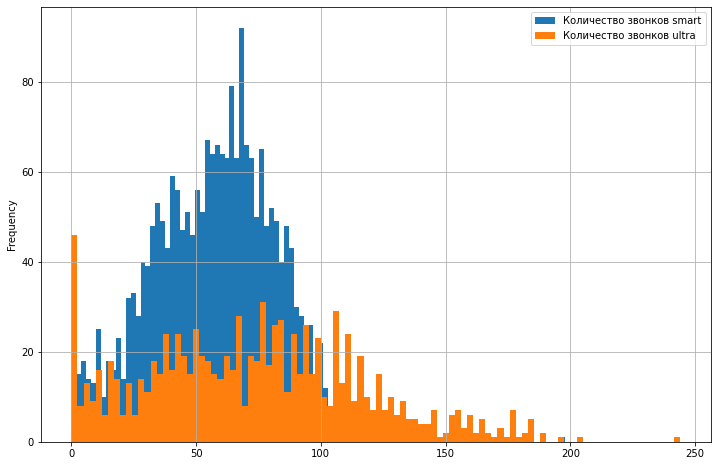

In [42]:
graph('calls_count', 100)

Количество звонков по тарифу ultra гораздно меньше на отрезке 0 < х < 100, где x - ultra.
Также выделяется пик в значение равном нулю по тарифу ultra. На отрезке х >= 100 пользователи ultra активнее, чем  пользователи smart.

График по smart выглядит практически похожим на нормальное распределение со скошенностью слева.
График по ultra выглядит произвольным.


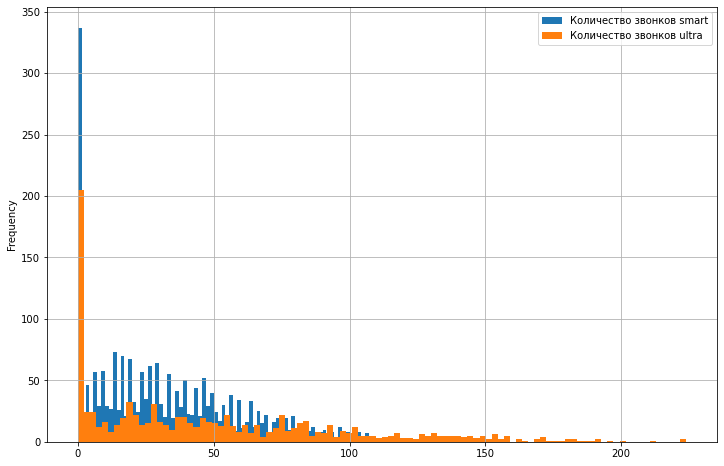

In [43]:
graph('messages', 100)

Графики по smart и ultra выглядят произвольными. Пик у обоих графиков в нуле.

Заметим, что многие пользователи вовсе не отправляют сообщения. Можно предположить что это связано с использованием мессенжеров. Поэтому можно предположить, что использование происходит интернета происходит в больших количествах. Докажим.

In [44]:
messages = round(group_data.loc[group_data['messages'] == 0]['internet'].mean(), 2)
print('\033[1m' + 'Потрачено ГБ без сообщений:' + '\033[0m', messages)
print('\033[1m' + 'ГБ c сообщениями:' + '\033[0m', round(group_data['messages'].mean()))

Потрачено ГБ без сообщений: 17.6
ГБ c сообщениями: 38


Люди, отправляющие сообщения по телефону, тратят в среднем  больше интернета, чем те, кто этого наоборот не отправляет сообщения.

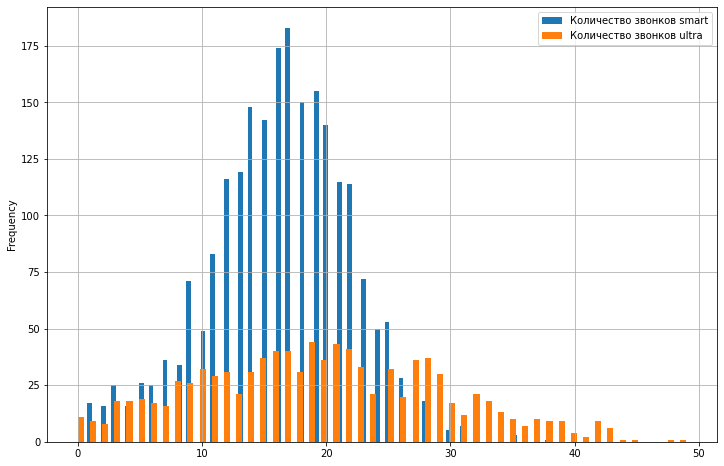

In [45]:
graph('internet', 100)

Пользователи smart больше используют интернет, чем пользователи ultra. Но примерно с 25 ГБ и больше заметна обратная тенденция. Это связано с тем что пользователям smart с 15 ГБ и более приходится дополнительно платить за интернет, а у пользователей ultra пороговое значение выше (30 Гб).

**Графики по smart и ultra похожи на нормальное распределение.**

Выведим количество пользователей по тарифам

In [46]:
group_data['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

**Построим график** по выручке в зависимости от тарифа.

In [47]:
def pay_tariff(aggfunc):
    pay_smart = group_data.query('tariff == "smart"').pivot_table(index='month', values='pay', aggfunc = aggfunc)
    pay_ultra = group_data.query('tariff == "ultra"').pivot_table(index='month', values='pay', aggfunc = aggfunc)
    return pay_smart, pay_ultra

In [48]:
def info_graph(smart_columns, ultra_columns, aggfunc):
    pay_smart = pay_tariff(aggfunc)[0]
    pay_ultra = pay_tariff(aggfunc)[1]
    
    pay_smart.columns = ['Медиана smart']
    pay_ultra.columns = ['Медиана ultra']

    ax = (pay_smart
          .plot(grid=True, 
                linewidth=2, 
                figsize=(12, 8)))
    (pay_ultra
     .plot(ax=ax, 
           alpha=0.7, 
           grid = True, 
           legend=True,
           linewidth=2,
           figsize=(12, 8)));

    print(pay_smart.median())
    print(pay_ultra.median())

Медиана smart    969.75
dtype: float64
Медиана ultra    1950.0
dtype: float64


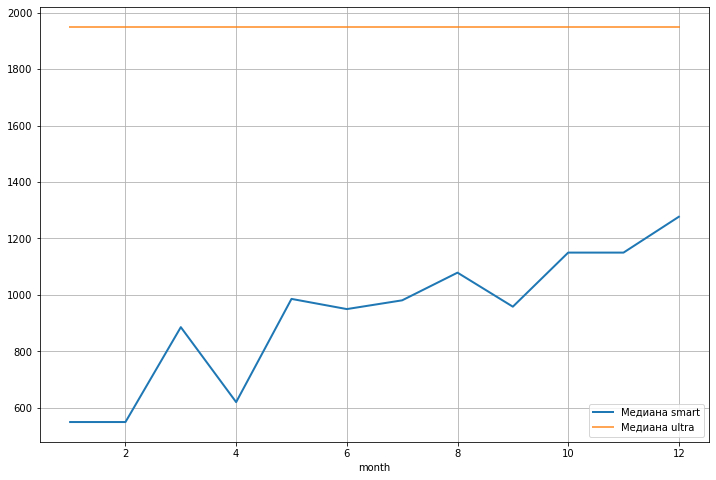

In [49]:
info_graph('Медиана smart', 'Медиана ultra', 'median')

Медиана smart    1213.984271
dtype: float64
Медиана ultra    2049.493603
dtype: float64


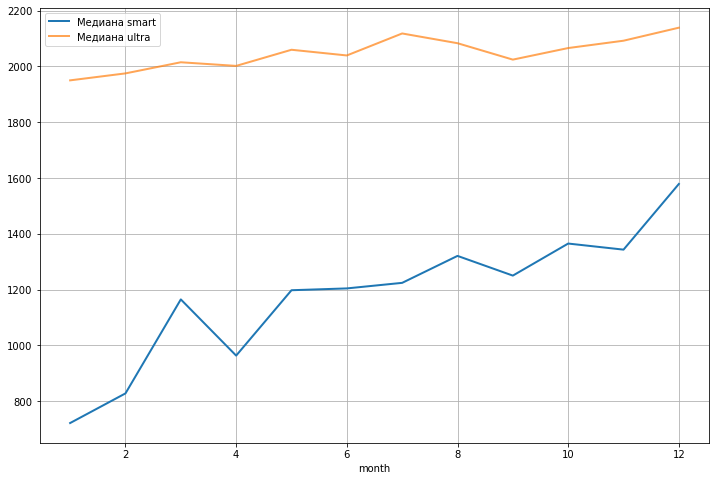

In [50]:
info_graph('Среднее smart', 'Среднее ultra', 'mean')

### Вывод

По полученным значениям видно, что тариф ultra больше приносит выручки компании. При предложении клиенту тарифа следует порекомендовать smart в случае если он: осуществляет количество звонков меньше 750, отправляет до 50 сообщений и использует менее 25 ГБ интернета. В противном случае рекомедовать тариф ultra.

## Проверка гипотез

Проверка гипотез является важным шагом в аналитике поэтому необходимо провести исследование.

Гипотеза H0: "средняя выручка пользователей тарифов «Ультра» и «Смарт» равна". Альтернативная гипотеза H1: "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются."

Тест двусторонний, т.к. не сказано что нужно проверить больше или меньше полученное значение. Есть сомнения, что дисперсии у совокупностей одинаковые, поэтому указываем equal_var = False

In [51]:
ALPHA = .05

smart = data_smart['pay']
ultra = data_ultra['pay']

results = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < ALPHA:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print(' ')    
print('Среднее значение: ', pay_tariff('mean')[0].mean())
print('Среднее значение: ', pay_tariff('mean')[1].mean())

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу
 
Среднее значение:  pay    1179.924424
dtype: float64
Среднее значение:  pay    2046.932856
dtype: float64


На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативы.
Содержательный вывод: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.


**Проверяем следующую гипотезу.**

Гипотеза H0: "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".Альтернативная гипотеза H1: "средняя выручка пользователей из Москвы равна выручке пользователей из других регионов".


Разграничиваем Москву и другие города.

In [52]:
def city(row): 
    if row['city'] == 'Москва':
        return 'Москва'
    return 'Другой'

In [53]:
data_users['city_group'] = data_users.apply(city, axis=1)

In [54]:
group_city = group_data.merge(data_users, on = 'user_id')

In [56]:
group_city = group_city[['month', 'user_id', 'tariff_x', 'pay', 'city', 'city_group']]
group_city = group_city.rename(columns={'tariff_x' : 'tariff'})

In [57]:
group_city_moscow = group_city.loc[group_city['city_group'] == 'Москва']
group_city_other = group_city.loc[group_city['city_group'] == 'Другой']

,month,user_id,tariff,pay,city,city_group
0,1,1005,smart,550,Набережные Челны,Другой
1,2,1005,smart,550,Набережные Челны,Другой
2,3,1005,smart,886,Набережные Челны,Другой
3,4,1005,smart,1186,Набережные Челны,Другой
4,5,1005,smart,835,Набережные Челны,Другой
...,...,...,...,...,...,...
3209,11,1489,smart,1150,Санкт-Петербург,Другой
3210,12,1489,smart,950,Санкт-Петербург,Другой
3211,10,1328,ultra,1950,Мурманск,Другой
3212,11,1328,ultra,2700,Мурманск,Другой


In [59]:
show(group_city)

,month,user_id,tariff,pay,city,city_group
0,1,1005,smart,550,Набережные Челны,Другой
1,2,1005,smart,550,Набережные Челны,Другой
2,3,1005,smart,886,Набережные Челны,Другой
3,4,1005,smart,1186,Набережные Челны,Другой
4,5,1005,smart,835,Набережные Челны,Другой


,month,user_id,tariff,pay,city,city_group
3209,11,1489,smart,1150,Санкт-Петербург,Другой
3210,12,1489,smart,950,Санкт-Петербург,Другой
3211,10,1328,ultra,1950,Мурманск,Другой
3212,11,1328,ultra,2700,Мурманск,Другой
3213,12,1328,ultra,3300,Мурманск,Другой


In [58]:
moscow = group_city_moscow['pay']
other = group_city_other['pay']

results = st.ttest_ind(
    moscow, 
    other)

print('p-значение:', results.pvalue)

if results.pvalue < ALPHA:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) нет оснований отвергнуть нулевую гипотезу в пользу альтернативы.
Содержательный вывод: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Общий вывод

Проведено исследование «Мегалайн» — федерального оператора сотовой связи. Проанализировано поведение клиентов, изначальные данные предобработны, и их на основе были проверены гипотезы. Подметим, что пользователи обоих тарифов не охотно пользуются сообщениями о чем свидетельствует пик в нуле. Так же пользователи смарт активнее используют звонки в пределах до 100 звонков, при больших значениях видна обратная тенденция. Видно и различие в использовании интернета - пользователи смарт активнее пользуются интернетом до 25 ГБ.  

По резутатам гипотез для оператора сотовой связи тариф ультра выгоднее, поэтому для получения ещё большей выручки рекомендуется рекламировать именно этот тариф.

## Чек-лист 

- [x]  Как вы описываете выявленные в данных проблемы?
- [x]  Как готовите данные к анализу?
- [x]  Какие графики строите для распределений?
- [x]  Как интерпретируете полученные графики?
- [x]  Как рассчитываете стандартное отклонение и дисперсию?
- [x]  Формулируете ли альтернативную и нулевую гипотезы?
- [x]  Какие методы применяете для проверки гипотез?
- [x]  Интерпретируете ли результат проверки гипотезы?
- [x]  Соблюдаете структуру проекта и поддерживаете аккуратность кода?
- [x]  Какие выводы делаете?
- [x]  Оставляете ли комментарии к шагам?
